In [410]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np


In [411]:
batch_size = 16
image_size = 64
nz = 128  # Size of the latent vector (input to the generator)
ngf = 64  # Number of generator feature maps
ndf = 64  # Number of discriminator feature maps
num_epochs = 600
lr = 0.0005
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizer
real_label = 0.9  # Instead of 1 for real labels
fake_label = 0.0
nc=3



In [412]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is the latent vector Z
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # State size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # State size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # State size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # State size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [413]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False),  # Changed to 3x3 kernel
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # State size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output state size. 1 (real/fake prediction) x 1 x 1
        )

    def forward(self, input):
        return self.main(input)


In [414]:
dataset = datasets.ImageFolder(root='C:/Users/nehar/OneDrive/Desktop/teachnook/apple',
                               transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [415]:
device = torch.device("cpu")
netG = Generator().to(device)
netD = Discriminator().to(device)


In [416]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [417]:
import os
import torch
import torchvision.utils as vutils
   
output_dir = 'D:/project1/epoch'
os.makedirs(output_dir, exist_ok=True)

# Training loop with label smoothing
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator with real data
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)  # label smoothing
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()

        # Train Discriminator with fake data
        noise = torch.randn(batch_size, nz, 1, 1, device=device) * 0.7  # Truncating noise to reduce randomness
        fake_images = netG(noise)
        label.fill_(fake_label)
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, label)
        lossD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)  # Use real label for generator's training
        output = netD(fake_images).view(-1)
        lossG = criterion(output, label)
        lossG.backward()
        optimizerG.step()

        # Print Losses
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {lossD_real + lossD_fake:.4f}, G Loss: {lossG:.4f}")
            save_path = os.path.join(output_dir, f'generated_images_epoch_{epoch}.png')
            vutils.save_image(fake_images, save_path, normalize=True)
            print(f'Saved images for epoch {epoch} at {save_path}')


Epoch [0/600], Step [0/3], D Loss: 1.3336, G Loss: 6.6503
Saved images for epoch 0 at D:/project1/epoch\generated_images_epoch_0.png
Epoch [1/600], Step [0/3], D Loss: 0.8285, G Loss: 9.4426
Saved images for epoch 1 at D:/project1/epoch\generated_images_epoch_1.png
Epoch [2/600], Step [0/3], D Loss: 0.4061, G Loss: 10.6357
Saved images for epoch 2 at D:/project1/epoch\generated_images_epoch_2.png
Epoch [3/600], Step [0/3], D Loss: 0.4092, G Loss: 9.4399
Saved images for epoch 3 at D:/project1/epoch\generated_images_epoch_3.png
Epoch [4/600], Step [0/3], D Loss: 0.6210, G Loss: 7.3766
Saved images for epoch 4 at D:/project1/epoch\generated_images_epoch_4.png
Epoch [5/600], Step [0/3], D Loss: 0.6944, G Loss: 6.9786
Saved images for epoch 5 at D:/project1/epoch\generated_images_epoch_5.png
Epoch [6/600], Step [0/3], D Loss: 0.5398, G Loss: 8.4170
Saved images for epoch 6 at D:/project1/epoch\generated_images_epoch_6.png
Epoch [7/600], Step [0/3], D Loss: 2.3088, G Loss: 11.6053
Saved ima

In [418]:
with torch.no_grad():
    noise = torch.randn(64, nz, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()


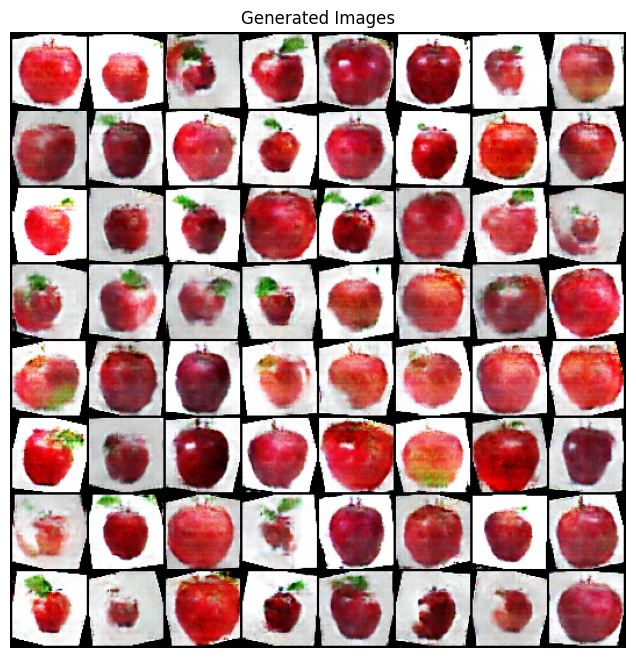

In [419]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()


In [420]:
import cv2
import numpy as np
import torchvision.utils as vutils

# Assuming `fake_images` is your batch of generated images
output_dir = 'D:/project1/generated_image'  # Directory to save images

for i, img in enumerate(fake_images):
    # Convert the PyTorch tensor to a NumPy array
    img_grid = vutils.make_grid(img, padding=2, normalize=True).cpu().numpy()
    img_np = np.transpose(img_grid, (1, 2, 0)) * 255  # Convert to HWC and scale to 0-255
    
    # Convert RGB to BGR for OpenCV saving
    img_bgr = cv2.cvtColor(img_np.astype(np.uint8), cv2.COLOR_RGB2BGR)
    output_path = f"{output_dir}/generated_image_{i}.png"
    cv2.imwrite(output_path, img_bgr)
    print(f"Saved {output_path}")


Saved D:/project1/generated_image/generated_image_0.png
Saved D:/project1/generated_image/generated_image_1.png
Saved D:/project1/generated_image/generated_image_2.png
Saved D:/project1/generated_image/generated_image_3.png
Saved D:/project1/generated_image/generated_image_4.png
Saved D:/project1/generated_image/generated_image_5.png
Saved D:/project1/generated_image/generated_image_6.png
Saved D:/project1/generated_image/generated_image_7.png
Saved D:/project1/generated_image/generated_image_8.png
Saved D:/project1/generated_image/generated_image_9.png
Saved D:/project1/generated_image/generated_image_10.png
Saved D:/project1/generated_image/generated_image_11.png
Saved D:/project1/generated_image/generated_image_12.png
Saved D:/project1/generated_image/generated_image_13.png
Saved D:/project1/generated_image/generated_image_14.png
Saved D:/project1/generated_image/generated_image_15.png
Saved D:/project1/generated_image/generated_image_16.png
Saved D:/project1/generated_image/generat

In [422]:
import cv2
import os
import numpy as np

# Path to template image
template_path = 'C:/Users/nehar/OneDrive/Desktop/teachnook/apple/apple_images/13.jpg'
template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)

# Verify that the template image loaded correctly
if template is None:
    print(f"Failed to load template image at {template_path}. Please check the path and try again.")
else:
    # Apply Gaussian blur to the template
    template = cv2.GaussianBlur(template, (5, 5), 0)  # (5, 5) is the kernel size; adjust if needed
    template_height, template_width = template.shape[:2]
    threshold = 0.3  # Adjusted matching threshold

    # Directory with generated images
    output_dir = 'D:/project1/generated_image/'

    # Iterate over the saved generated images
    for i, image_file in enumerate(os.listdir(output_dir)):
        image_path = os.path.join(output_dir, image_file)

        # Load each generated image
        generated_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if generated_image is None:
            print(f"Failed to load {image_path}")
            continue

        # Apply Gaussian blur to the generated image
        generated_image = cv2.GaussianBlur(generated_image, (5, 5), 0)

        # Perform template matching
        result = cv2.matchTemplate(generated_image, template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        # Check if the match is above the threshold
        if max_val >= threshold:
            print(f"{image_file}: Likely an apple (Match: {max_val:.2f})")
        else:
            print(f"{image_file}: Not an apple (Match: {max_val:.2f})")


generated_image_0.png: Likely an apple (Match: 0.51)
generated_image_1.png: Likely an apple (Match: 0.43)
generated_image_10.png: Likely an apple (Match: 0.54)
generated_image_11.png: Likely an apple (Match: 0.49)
generated_image_12.png: Likely an apple (Match: 0.50)
generated_image_13.png: Likely an apple (Match: 0.47)
generated_image_14.png: Likely an apple (Match: 0.39)
generated_image_15.png: Likely an apple (Match: 0.43)
generated_image_16.png: Likely an apple (Match: 0.41)
generated_image_17.png: Likely an apple (Match: 0.42)
generated_image_18.png: Likely an apple (Match: 0.45)
generated_image_19.png: Likely an apple (Match: 0.43)
generated_image_2.png: Likely an apple (Match: 0.61)
generated_image_20.png: Likely an apple (Match: 0.39)
generated_image_21.png: Likely an apple (Match: 0.48)
generated_image_22.png: Likely an apple (Match: 0.36)
generated_image_23.png: Likely an apple (Match: 0.45)
generated_image_24.png: Likely an apple (Match: 0.54)
generated_image_25.png: Likely 

In [ ]:
import matplotlib.pyplot as plt

# D Loss and G Loss values from the logs
d_loss = [
    1.3336, 0.8285, 0.4061, 0.4092, 0.6210, 0.6944, 0.5398, 2.3088, 0.4517, 0.4121, 
    0.7820, 1.0084, 0.7081, 0.5780, 0.3797, 0.4540, 0.3762, 0.6114, 1.4301, 0.8594, 
    0.9768, 0.8002, 1.6933, 0.4942, 0.4092, 2.0530, 1.1754, 0.4765, 0.7490, 1.0199, 
    0.5887, 0.6401, 0.5620, 0.5443, 1.1036, 0.9121, 0.7459, 0.7033, 0.6075, 0.6037, 
    1.6556, 1.6928, 0.9737, 0.6406, 0.7833, 0.6325, 0.9490, 0.8253, 1.0451, 1.1925, 
    0.8811, 0.9017, 0.9232, 0.5571, 0.8969, 1.2364, 1.1027, 0.6635, 1.0500, 0.8708, 
    1.0444, 1.0443, 0.8263, 1.0328, 0.8470, 0.9224, 2.6565, 0.9458, 0.9967, 1.2032, 
    0.8309, 0.8472, 1.3787, 1.3227, 0.9687, 1.0650, 0.6906, 0.8335, 0.7414, 1.2756, 
    1.1474, 0.8338, 1.0942, 0.8179, 0.8073, 0.9124, 0.7961, 0.6532, 1.5254, 0.7827, 
    0.7827, 1.1935, 0.6014, 0.9930, 0.8221, 0.9404, 1.5372, 0.6293, 0.6929, 1.8506, 
    0.9235, 0.6389, 1.1943, 0.8132, 0.9358, 1.1563, 0.8217, 0.6965, 0.6366, 0.8233, 
    0.8472, 1.3787, 0.6616, 1.2900, 1.0273, 0.9010, 1.0023, 0.9676, 1.3594, 1.7368
]

g_loss = [
    6.6503, 9.4426, 10.6357, 9.4399, 7.3766, 6.9786, 8.4170, 11.6053, 5.6176, 8.8485,
    9.8757, 9.3169, 6.1921, 5.9378, 6.1513, 4.1246, 6.5106, 6.0266, 7.0832, 6.2343,
    6.8666, 6.7730, 10.6166, 3.3360, 5.2105, 5.3439, 6.8271, 4.9298, 6.2437, 7.5375,
    4.7151, 4.1976, 3.1203, 5.9121, 4.2066, 3.3327, 3.8001, 2.9725, 2.5075, 3.1384,
    7.5631, 4.3355, 3.8708, 4.0547, 4.6463, 5.3584, 4.2848, 4.8758, 3.8145, 3.9818,
    5.3676, 6.6740, 3.2948, 2.8501, 3.5762, 1.3488, 1.6583, 2.4103, 3.1235, 3.7754,
    1.4221, 3.4301, 3.1479, 2.5602, 1.9805, 3.1667, 7.1984, 3.5035, 3.3971, 5.4166,
    3.6722, 3.3068, 2.8133, 1.9651, 2.4364, 4.3477, 2.5322, 2.8356, 4.6869, 3.1473,
    2.3099, 2.7194, 2.0938, 2.7682, 3.5908, 5.9400, 3.6369, 3.3306, 2.6910, 3.0415,
    3.8342, 2.5789, 2.9446, 3.4911, 4.9270, 6.6348, 1.5464, 3.0048, 3.6956, 1.7207,
    3.3770, 3.6181, 1.6701, 3.6939, 1.5984, 4.4146, 3.6278, 3.2122, 2.3385, 1.4188,
    2.1785, 4.2226, 2.9740, 1.4588, 1.7221, 3.0635, 3.3668, 2.6791, 2.4825, 5.6391,
    5.6660, 3.5793, 3.7445, 6.3614, 3.3219, 2.1821, 2.3668, 3.0546, 2.6523, 3.0377,
    5.1238, 3.7085, 2.2850, 1.9560, 2.9237, 3.3693, 2.3104, 3.8190, 5.5182, 3.1793,
    7.7691, 1.3268, 1.9715, 3.2440, 3.4756, 3.6948, 2.8180, 2.7281, 2.2716, 2.5974,
    1.9359, 2.8184, 1.9425, 4.0704, 4.3962, 3.0197, 2.6796, 1.9507, 2.5497, 3.3329
]

# Plotting D Loss and G Loss
epochs = range(600)

plt.figure(figsize=(10, 6))
plt.plot(epochs[:len(d_loss)], d_loss, label='D Loss', color='blue')
plt.plot(epochs[:len(g_loss)], g_loss, label='G Loss', color='red')

plt.title("D Loss vs G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()